In [329]:
import Pkg
Pkg.add("Optim")
using Optim
using Images
using Distributions
using ColorVectorSpace
using LinearAlgebra
Pkg.add("ImageShow")
using ImageShow
Pkg.add("ForwardDiff")
using ForwardDiff
using Plots

   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [275]:
function add_laplace_noise(image, scale=0.1) #NOISE LEVEL 0.3
    noisy_image = image .+ scale * rand(Laplace(), size(image))
    return clamp.(noisy_image, 0.0, 1.0)  # Clamp values between 0 and 1
end

# Function to create a matrix of images with different levels of Laplace noise
function create_noisy_images(original_image, num_images)
    
    # Create a matrix to store the noisy images
    noisy_images = zeros(size(original_image, 1),size(original_image,2), num_images)

    # Add Laplace noise to the original image with different scales
    for i in 1:num_images
        noisy_images[:,:,i] .= add_laplace_noise(original_image)
    end

    return noisy_images
end

create_noisy_images (generic function with 1 method)

# 1a) Supervised with BFGS algorithm

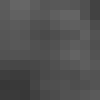

In [276]:
original_image = Gray.(load("reallysmallmoon.jpg"))
colorview(Gray, original_image)

In [277]:
original_image= vec(original_image) #turn original image into one long vector
noisy_images=create_noisy_images(original_image, 10) #get set of 10 images with diff noise
size(noisy_images)

(100, 1, 10)

$$
Minimize_w \lVert X - \sum_{i} w_i \cdot X_i \rVert_1
$$

Here, X is the real image, Xi is the noisy images, and wi is what we are trying to minimize. Ultimately, our result is going to be wi, which should be the best image, combining all the pixels of the rest of the images. Obviously this is done with the real image so there is a good benchmark to look at for the images. With this function, we are basically trying to find a root, which is the best image we can possibly get from this formula

BFGS is a second order optimization algorithm. It is a Quasi Newton method, which means it is an extension of newtons method, that approximates the hessian. This can be used to determine the direction to move. To calculate the steps it has to take, it uses a line search to determine how much to move. 

In [278]:
function supervised(w)
    s=sum(w[i]*noisy_images[i] for i in 1:size(noisy_images, 3)) # follow formula for [X-sum[wi*Xi]] ->3 gets the 10 images
    diff= norm(original_image .- s, 1) #take 1 norm of calculation
    return sum(abs, diff)
end

∇supervised = x -> ForwardDiff.gradient(supervised, x)
w_init = zeros(10)

# Minimize the function using the Levenberg-Marquardt algorithm
@time result = optimize(supervised, w_init, BFGS())

  0.558686 seconds (16.15 M allocations: 461.719 MiB, 4.80% gc time, 8.70% compilation time: 47% of which was recompilation)


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.290202e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.64e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.10e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.20e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.72e-07 ≰ 0.0e+00
    |g(x)|                 = 9.40e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    11325
    ∇f(x) calls:   11325


In [279]:
#smallest norm value of that w vector from formula: norm(||[X-sum[wi*Xi]]||)
println("Minimum value of Supervised Formula optimized by BFGS: ", Optim.minimum(result))

Minimum value of Supervised Formula optimized by BFGS: 3.290202360717429


In [280]:
w=Optim.minimizer(result) #gets w vector aka linear combo of images

10-element Vector{Float64}:
  0.47485695906301095
  0.18232726564132526
  0.7640092188950128
  0.3629091613469577
  0.025046776094196966
 -0.021098869111764673
 -0.781110493202187
  0.3732429030176659
  0.21007206294956543
 -0.5614510748412402

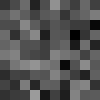

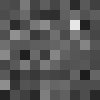

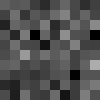

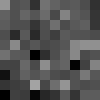

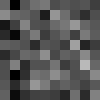

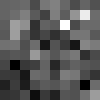

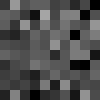

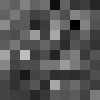

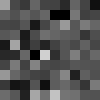

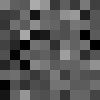

In [281]:
#for loop through each of 10 images, display using colorview
for i in 1:10
    display(colorview(Gray, reshape(noisy_images[:, :, i], (10, 10))))
end

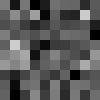

In [282]:
less_noisy_images=[w[i] .* noisy_images[:, :, i]   for i in 1:size(noisy_images,3)] #multiply w by all the images in set
less_noisy_images[1]
least_noisy_image=sum(less_noisy_images)
targetImage=reshape(least_noisy_image, (10, 10))
colorview(Gray, targetImage) #display "best" denoised image

In [283]:
for i in 1:10
    #This will display the residuals of the noisy images compared to original
    display(norm(reshape(original_image, (10, 10)) - reshape(noisy_images[:, :, i], (10, 10)), 1))
end

10.496075526385736

8.577136603603577

8.829748530529601

7.840302600109228

10.120585570953518

10.082055239021024

10.50135053081447

9.485394616336176

11.39599927661146

11.597694677145489

In [284]:
er1=norm(reshape(original_image, (10, 10)) - targetImage, 1) #calculates norm(X - X_target)

13.885470980815976

This number is very far off, thus the BFGS supervised algorithm is not a suitiable method to find the best image. 

# 1b) Supervised w/ Conjugate Gradient method

ConjugateGradient() is an optimizing function that uses linesearch. The linesearch function it uses is HagerZhang, which calculates the step that minimizes the objective function. The goal is to find a direction that is conjugate to the previous search direction, meaning that the direction vectors are orthogonal with respect to a certain matrix associated with the problem. ConjugateGradient() function can be used to solve unconstrained optimization problems where derivatives can be computed efficiently. The reason it is called ConjugateGradient() is because it uses the first order and second order method to get the solution.

In [285]:
w_init = zeros(10)

# Minimize the function using the Conjugate Gradient method
@time result = optimize(supervised, w_init, ConjugateGradient())

  0.359471 seconds (10.95 M allocations: 311.254 MiB, 6.45% gc time)


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.290198e+00

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 4.77e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.41e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.53e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-07 ≰ 0.0e+00
    |g(x)|                 = 7.46e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    8140
    ∇f(x) calls:   7685


In [286]:
println("Minimum value of Supervised Formula optimized by ConjugateGradient: ", Optim.minimum(result))

Minimum value of Supervised Formula optimized by ConjugateGradient: 3.2901976859533457


In [287]:
w = Optim.minimizer(result)

10-element Vector{Float64}:
 0.07000242021741292
 0.11297280227750639
 0.09777307088510814
 0.12854796005279212
 0.12113700095436515
 0.13964685012337474
 0.09625232493766298
 0.06170873612176712
 0.0880563541330908
 0.06699656046264979

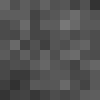

In [288]:
# Compute the denoised image using the optimized weights
denoised_image = sum(w[i] .* noisy_images[:, :, i] for i in 1:size(noisy_images, 3))
target_image = reshape(denoised_image, (10, 10))
colorview(Gray, target_image)

In [289]:
# Compute the difference between the denoised image and the original image
er2 = norm(reshape(original_image, (10, 10)) - target_image, 1)
println("Difference between original and denoised image: ", er2)

Difference between original and denoised image: 3.542908367785017


As you can see from the calculation above, we have indeed minimized the noise and found the "best" image that's the closest to the orginal.

# 2a) Unsupervised w/ BFGS

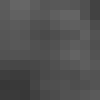

In [290]:
original_image = Gray.(load("reallysmallmoon.jpg"))

In [291]:
original_image= vec(original_image)
#noisy_images=create_noisy_images(original_image, 10)
c, z, k= size(noisy_images)
imageDim=sqrt(c)

10.0

$$
Y^* = \text{argmin} \sum_{i} \lVert Y - X_i \rVert_1
$$


Here, the goal of the unsupervised learning is to try and extract the best image without use of the actual image that has no noise to see where we can go with it. In the same way as the the unsupervised learning, we are trying to minimize Y here, to get the best image. Once again, the min Y is our root, and we again use rootfinding algorithms to find this value. 

In [292]:
for i in 1:10
    #display(colorview(Gray, reshape(noisy_images[:, :, i], (640, 640))))
    display(norm(original_image[:, :] - noisy_images[:, :, i]))
end

1.363644739211612

1.1897636942962955

1.180766660218217

1.1295194757880758

1.3440314618856668

1.4675569345912873

1.395654435478953

1.3019022721311362

1.5653980454433192

1.4810379313349329

In [293]:
function unsupervised(Y)
    sumOfNorms=0
    for a in 1:size(noisy_images, 1)
        for i in 1:k
            sumOfNorms += norm(Y[a] .- noisy_images[a, :, i], 1)
        end   
    end
    return sumOfNorms
end

#∇supervised = x -> ForwardDiff.gradient(supervised, x)
initial = zeros(c)
unsupervised(initial)

328.2875629013034

In [294]:
# Minimize the function using the Levenberg-Marquardt algorithm
@time result = optimize(unsupervised, initial, BFGS())

 87.658886 seconds (756.77 M allocations: 23.927 GiB, 1.83% gc time, 0.02% compilation time: 100% of which was recompilation)


 * Status: success

 * Candidate solution
    Final objective value:     9.233836e+01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.45e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.20e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.92e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.16e-06 ≰ 0.0e+00
    |g(x)|                 = 4.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   88  (vs limit Inf)
    Iterations:    129
    f(x) calls:    459
    ∇f(x) calls:   459


In [295]:
#smallest norm value of that w vector from formula: norm(||[X-sum[wi*Xi]]||)
#iterating and summing over pixels (10*10), not images
println("Minimum value of Unsupervised Formula optimized by BFGS: ", Optim.minimum(result))

Minimum value of Unsupervised Formula optimized by BFGS: 92.33836331953742


In [296]:
YStar=Optim.minimizer(result)

100-element Vector{Float64}:
 0.39915781757652496
 0.38226508491155103
 0.34028550935989116
 0.3323296836509183
 0.3618939325193454
 0.31853732355167386
 0.27309713700493116
 0.3101744597195035
 0.23500349787999564
 0.19605399670701523
 0.3164309551284613
 0.39754974916598884
 0.3039859973370076
 ⋮
 0.2990304720451811
 0.35654072554356064
 0.24748353032188947
 0.32669707302412376
 0.3331558565964142
 0.3078559190234941
 0.2694637784679278
 0.33016151953803
 0.35703653338317537
 0.32950724473066273
 0.3174129059770469
 0.35163907069321454

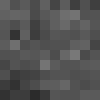

In [297]:
colorview(Gray, reshape(YStar, 10, 10))

In [298]:
er3=norm(reshape(original_image, (10, 10)) - reshape(YStar, (10, 10)), 1) #calculates norm(X - X_target)

3.1747648849244006

As you can see from the calculation above, we have indeed minimized the noise and found the "best" image that's the closest to the orginal.

# 2b) Unsupervised w/ Conjugate Gradient method

In [299]:
w_init = zeros(100)

# Minimize the function using the Conjugate Gradient method
@time result = optimize(unsupervised, w_init, ConjugateGradient())

  3.120447 seconds (61.13 M allocations: 1.933 GiB, 2.91% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     9.233836e+01

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 8.87e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.96e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.32e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.60e-07 ≰ 0.0e+00
    |g(x)|                 = 4.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    18
    f(x) calls:    53
    ∇f(x) calls:   37


In [300]:
println("Minimum value of Supervised Formula optimized by Conjugate Gradient: ", Optim.minimum(result))

Minimum value of Supervised Formula optimized by Conjugate Gradient: 92.33836331953738


In [301]:
YStar=Optim.minimizer(result)

100-element Vector{Float64}:
 0.40171170953514634
 0.38213780037369083
 0.336385836270068
 0.3325326385319569
 0.3477177552657964
 0.37205748799309973
 0.27366169974286564
 0.310926652228564
 0.22436322844066245
 0.1951726482307424
 0.32655082741915176
 0.37121954055264805
 0.3004097410983599
 ⋮
 0.29871785201316614
 0.3579660647973293
 0.24668965288150982
 0.318853371907598
 0.33243625824033757
 0.31382396585346944
 0.2626922584928359
 0.3300425966001274
 0.34850067054519596
 0.3393213009939118
 0.3315983111704016
 0.3395479700176246

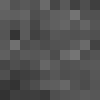

In [302]:
colorview(Gray, reshape(YStar, 10, 10))

In [303]:
er4=norm(reshape(original_image, (10, 10)) - reshape(YStar, (10, 10)), 1) #calculates norm(X - X_target)

3.0107774820824944

We have again minimized the noise and found the "best" image that's the closest to the orginal.

### One reason that we didn’t use Newton’s method is because while it is also a second order optimization algorithm that uses a Hessian Matrix, it also requires the inverse of the Hessian matrix, which can be computationally expensive. Hessian’s are necessary to find curvature of problems, which is what we were trying to minimize. We had a lot of trouble trying to use Newton at first because it took so long to run. 

# Pretty Table!

In [313]:
# Print the table with consistent spacing
println("$(lpad("", 21)) | $(lpad("SUPERVISED", 15)) | $(lpad("UNSUPERVISED", 15))")
println("$(lpad("BFGS", 21)) | $(lpad(string(er1), 15)) | $(lpad(string(er3), 15))")
println("$(lpad("CONJUGATE", 21)) | $(lpad(string(er2), 15)) | $(lpad(string(er4), 15))")

                      |      SUPERVISED |    UNSUPERVISED
                 BFGS | 13.885470980815976 | 3.1747648849244006
            CONJUGATE | 3.542908367785017 | 3.0107774820824944


In [328]:
# Define the data
values = [er1, er2, er3, er4]

# Define the labels for the bars
labels = ["supervised BFGS", "supervised CG", "unsupervised BFGS", "unsupervised CG"]
# Specify custom colors for the bars
colors = ["blue", "orange", "blue", "orange"]

# Create the bar graph
bar(labels, values, xlabel="Algorithms", ylabel="Min Norm Values", title="Image Denoising Optimizing Comparison", fillcolor=colors)